# 1 - Introduction
The vehicle-reidentification is a current problem for security and surveillance, and thus the detection of suspicious activity, traffic and transport management. Finally, the re-identification system collects statistics on vehicle movements and driver behaviors, which are invaluable information for logistics and marketing companies.

In this exercise, we will build a re-identification system for vehicles using image retrieval. This work is divided into 6 parts: dataset description, data loading, data preprocessing, specification and training of model, evaluation of model.

# 2 - Dataset description: VeRi dataset
For this task, tha dataset VeRi will be used. This dataset contains images of different vehicles.
* It contains over 50,000 images of 776 vehicles captured by 20 cameras covering an 1.0 km$^2$ area in 24 hours, which makes the dataset scalable enough for vehicle Re-Id and other related research.
* The images are captured in a real-world unconstrained surveillance scene and labeled with varied attributes, e.g. BBoxes, types, colors, and brands. So complicated models can be learnt and evaluated for vehicle Re-Id.
* Each vehicle is captured by 2 - 18 cameras in different viewpoints, illuminations, resolutions, and occlusions, which provides high recurrence rate for vehicle Re-Id in practical surveillance environment.
* It is also labeled with sufficient license plates and spatiotemporal information, such as the BBoxes of plates, plate strings, the timestamps of vehicles, and the distances between neighbouring cameras.

Following some images and geographical positions of cameras

<style>
    table {
        border-collapse: collapse;
    }

    td, th {
        border: none;
    }
</style>

<table>
    <tr>
        <td>
          <img src="https://vehiclereid.github.io/VeRi/images/VeRi_240.png" alt="Description_de_l'image">
        </td>
        <td>
          <img src="https://vehiclereid.github.io/VeRi/images/VeRi2_240.png" alt="Description_de_l'image">
        </td>
    </tr>
    <!-- Ajoutez plus de lignes et de cellules au besoin -->
</table>
Source of images: https://github.com/JDAI-CV/VeRidataset






# Settings

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

base_dir = "gdrive/MyDrive/COMPUTER VISION/ASSIGNMENT 03/"

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
with ZipFile("gdrive/MyDrive/COMPUTER VISION/ASSIGNMENT 03/VeRi.zip", 'r') as zObject:
    zObject.extractall(path="./data")

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
!pip install imageio[pyav]
import cv2
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
!pip install torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import random
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.6 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3 - Data loading

The data file was loaded into drive in zip format and then unzipped. The next step is to create the structure of this dataset.

The __MyDataset__() class, created as follows, was used to do this work. For a given path of an image and a transformer, the __geititem__() method retrieves the image and its identifier in a tuple. This is how the three data sets train, test and query were loaded.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.data_paths = [(root_path+f) for f in os.listdir(root_path)]
        self.labels = [f[:4] for f in os.listdir(root_path)]
        self.transform = transform

    def __getitem__(self, idx):
        img = imageio.imread(self.data_paths[idx])
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.data_paths)

train_path = 'data/VeRi/image_train/'
test_path = 'data/VeRi/image_test/'
query_path = 'data/VeRi/image_query/'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set_init = MyDataset(root_path=train_path, transform=transform)
test_set = MyDataset(root_path=test_path, transform=transform)
query_set = MyDataset(root_path=query_path, transform=transform)

Because of computing capacity, we will use only 500 images in train set for train the model.

Then, each dataset was converted on PyTorch dataloader with batch size 5 as following

In [ ]:
train_set,_ = torch.utils.data.random_split(train_set_init, [5000, len(train_set_init)-5000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=False, num_workers=2)
query_loader = torch.utils.data.DataLoader(query_set, batch_size=5, shuffle=False, num_workers=2)

Let us show some images in train set

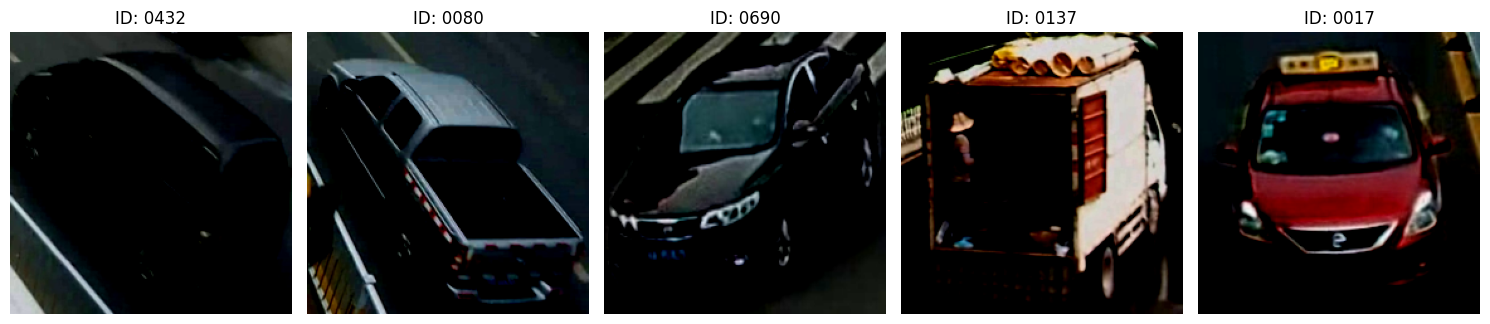

In [ ]:
figure, axes = plt.subplots(1,5, figsize=(15,5))
indexes = np.random.choice(range(len(train_set)), 5)
for i in range(len(indexes)):
    axes[i].imshow(np.clip(train_set[indexes[i]][0].permute(1, 2, 0), 0, 255))
    axes[i].set_title('ID: ' + train_set[indexes[i]][1])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

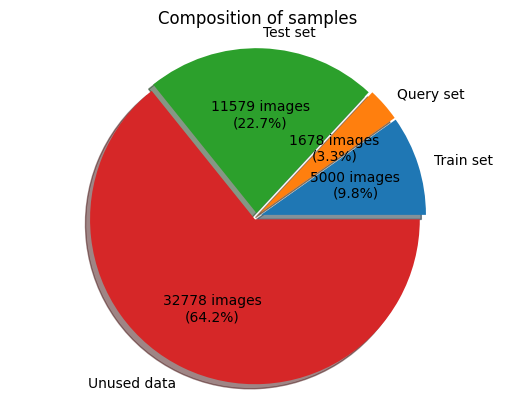

In [ ]:
y = np.array([len(train_set), len(query_set), len(test_set), len(train_set_init)-len(train_set)])
labels = ['Train set','Query set','Test set', 'Unused data']
myexplode = [0.03, 0.03, 0.02, 0.02]
total = len(train_set_init) + len(query_set) + len(test_set)
def my_fmt(x):
    return '{:.0f} images\n({:.1f}%)'.format(total*x/100, x)

plt.pie(y, labels=labels, shadow=True, explode=myexplode, autopct=my_fmt)
plt.title('Composition of samples')
plt.axis('equal')
plt.show()

Above the composition of samples used in this exercise. The training set have 5000 images (9.8% of dataset), the query set have the size of 1678 images (3.3% of dataset). The test set include 11 579 images and represent 22.7% of dataset. 32 778 (64.2% of dataset) images were excluded from the analysis due to lack of computing power.

# 4 - Data preprocessing

In this section, we will prepare data for model training. It consists to constitute triplets of images.

First, let us extract all images and all labels in train set

In [ ]:
import torch

all_images = []
all_labels = []

for images, labels in train_set:
    all_images.append(images)
    all_labels.append(labels)
    del images, labels
    torch.cuda.empty_cache()

all_labels = np.array(all_labels)

In [ ]:
anchor_labels = np.unique(all_labels)
anchor_images = [all_images[np.where(all_labels==i)[0][0]] for i in anchor_labels]

The triplets used in re-identification models are very important, as they determine the quality of the model. Let us denote by $d(E_{i},P_{j})$ is the distance between the enchor image $E_i$ and the positive image $P_j$, and $d(E_i,N_k)$ is the distance between the enchor image $E_i$ and the negative image $N_k$.

The ideal situation is to have triplets with :
$$
  d(E_{i},P_{j}) + \alpha < d(E_i,N_k)
$$
With $\alpha$ a hyperparameter set to 10.0

In [ ]:
def calculate_distances(anchor, positive, negative):
    distance_positive = torch.dist(anchor, positive, p=2)
    distance_negative = torch.dist(anchor, negative, p=2)
    return distance_positive, distance_negative

def hard_triplet_mining(anchors, labels, all_labels, all_images, alpha=10.0):
    triplets = []
    for i in tqdm(range(len(labels)), desc="Computing triplets....:"):
        anchor = anchors[i]
        anchor_label = labels[i]
        anchor_index = np.where(all_labels==anchor_label)[0][0]
        # Positives indexes
        mask1 = np.zeros(len(all_labels), dtype=bool)
        mask1[all_labels == anchor_label] = True
        mask1[np.array(range(len(all_labels))) == anchor_index] = False
        positive_indices = np.where(mask1)[0]
        # Negatives indexes
        mask2 = np.zeros(len(all_labels), dtype=bool)
        mask2[all_labels != anchor_label] = True
        negative_indices = np.where(mask2)[0]

        if len(positive_indices) > 0 and len(negative_indices) > 0:
            for positive_idx in positive_indices:
                negatives = negative_indices
                if len(negatives) > 5:
                  negatives = negative_indices[:5]

                for negative_idx in negatives:
                    positive_distance, negative_distance = calculate_distances(anchor, all_images[positive_idx], all_images[negative_idx])
                    if positive_distance + alpha <  negative_distance:
                        triplets.append((anchor, all_images[positive_idx], all_images[negative_idx]))

    return triplets

results_triplets = hard_triplet_mining(anchor_images, anchor_labels, all_labels, all_images)

Computing triplets....:: 100%|██████████| 571/571 [00:10<00:00, 52.30it/s]


Let us show two examples of triplets to be sure that the images in a same triplets are simillar.

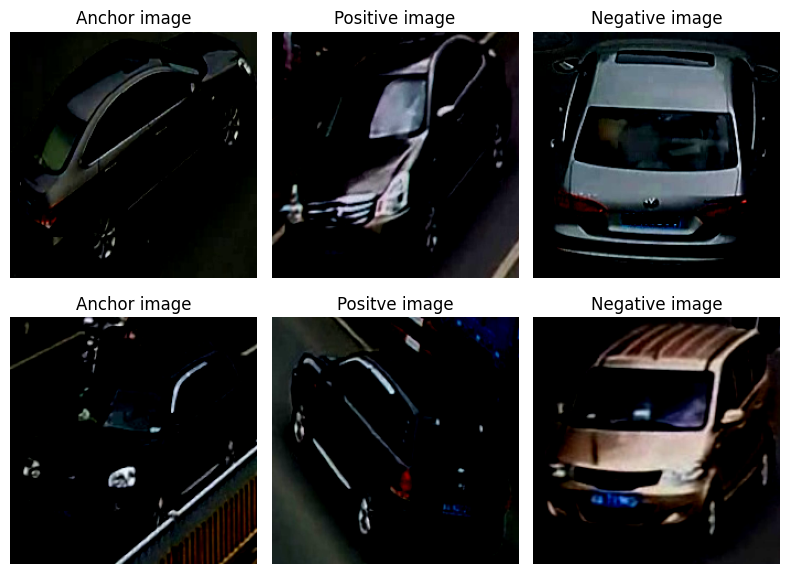

In [ ]:
figure, axes = plt.subplots(2,3, figsize=(8,6))
indexes = np.random.choice(range(len(results_triplets)), size=2)
axes[0,0].imshow(np.clip(results_triplets[indexes[0]][0].permute(1, 2, 0),0,1))
axes[0,0].set_title('Anchor image')
axes[0,0].axis('off')
axes[0,1].imshow(np.clip(results_triplets[indexes[0]][1].permute(1, 2, 0),0,1))
axes[0,1].set_title('Positive image')
axes[0,1].axis('off')
axes[0,2].imshow(np.clip(results_triplets[indexes[0]][2].permute(1, 2, 0),0,1))
axes[0,2].set_title('Negative image')
axes[0,2].axis('off')

axes[1,0].imshow(np.clip(results_triplets[indexes[1]][0].permute(1, 2, 0),0,1))
axes[1,0].set_title('Anchor image')
axes[1,0].axis('off')
axes[1,1].imshow(np.clip(results_triplets[indexes[1]][1].permute(1, 2, 0),0,1))
axes[1,1].set_title('Positve image')
axes[1,1].axis('off')
axes[1,2].imshow(np.clip(results_triplets[indexes[1]][2].permute(1, 2, 0),0,1))
axes[1,2].set_title('Negative image')
axes[1,2].axis('off')
plt.tight_layout()
plt.show()

As displayed, wer cxan see in each lines of this figure that anchor image and positive image are very similar bar not similar with negative image. Then our triplets seems good. Let us create a dataloader with batch size 5 with this triplets.

In [ ]:
triplets_dataloader = torch.utils.data.DataLoader(results_triplets, batch_size=32, shuffle=True, num_workers=2)

# 5 - Specification and estimation of image retrieval

For build a re-identification system, we will use transfert learning with resnet50 pretrained model. resnet50 is a CNN model with 50 layers.

The 50-layer ResNet architecture includes the following elements, as shown in the table below:

* A 7×7 kernel convolution alongside 64 other kernels with a 2-sized stride.
* A max pooling layer with a 2-sized stride.
* 9 more layers—3×3,64 kernel convolution, another with 1×1,64 kernels, and a third with 1×1,256 kernels. These 3 layers are repeated 3 times.
* 12 more layers with 1×1,128 kernels, 3×3,128 kernels, and 1×1,512 kernels, iterated 4 times.
* 18 more layers with 1×1,256 cores, and 2 cores 3×3,256 and 1×1,1024, iterated 6 times.
* 9 more layers with 1×1,512 cores, 3×3,512 cores, and 1×1,2048 cores iterated 3 times.
(up to this point the network has 50 layers)

* Average pooling, followed by a fully connected layer with 1000 nodes, using the softmax activation function.

Then restnet50 classify objects in 100 classes. For this image retrieval, the best choice is to replace the last fully connectedd layer with 9-fully connected layer. Because we have 9 types of vehicles.

Because of computional power, we will use only size 2 for last fully connected layer.

For the margin size, 1.0 was been used. And mini-batch size to 2.


In [ ]:
base_model = models.resnet50(pretrained=True)
base_model.fc = nn.Linear(base_model.fc.in_features, 3)

class EmbeddingNet(nn.Module):
    def __init__(self, base_model):
        super(EmbeddingNet, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        return self.base_model(x)

embedding_model = EmbeddingNet(base_model)
embedding_model = embedding_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 46.9MB/s]


In [ ]:
summary(embedding_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:

from tqdm import tqdm
import random

triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
triplet_loss=triplet_loss.to(device)

optimizer = optim.Adam(embedding_model.parameters(), lr=0.01)
epochs = 10
losses  = np.zeros((epochs))

for epoch in tqdm(range(epochs), desc="Training....:"):
    for anchor_image, positive_image, negative_image in triplets_dataloader:
        anchor_image = anchor_image.to(device)
        positive_image = positive_image.to(device)
        negative_image = negative_image.to(device)
        optimizer.zero_grad()
        anchor_output = embedding_model(anchor_image)
        positive_output = embedding_model(positive_image)
        negative_output = embedding_model(negative_image)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        loss.backward()
        losses[epoch] = loss.item()
        optimizer.step()

Training....:: 100%|██████████| 10/10 [1:00:48<00:00, 364.88s/it]


# 6 - Evaluation of the model

The evaluation of this model have two parts. First, we will inspect some images in output of the model. The goal is to verify if the query features and test features are simillar. Secondly, we will calculate mAP on test to quantify the model quality.

In [ ]:
query_features = []
test_features = []

with torch.no_grad():
    for query_image, label in query_loader:
        query_image = query_image.to(device)
        query_output = embedding_model(query_image)
        query_features.append(query_output)

    for test_image, label in test_loader:
        test_image = test_image.to(device)
        test_output = embedding_model(test_image)
        test_features.append(test_output)

query_features = torch.cat(query_features, dim=0)
test_features = torch.cat(test_features, dim=0)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distances = euclidean_distances(query_features.cpu().numpy(), test_features.cpu().numpy())


In [ ]:
def get_top5(idx, distances):
  sorted_indices = np.argsort(-distances[idx])
  five_max_positions = sorted_indices[:5]
  return five_max_positions

In [ ]:
def visual_inspect(queries,distances, query_set=query_set, test_set=test_set):
  figure, axes = plt.subplots(len(queries),6, figsize=(15,3*len(queries)))
  for i in range(len(queries)):
    axes[i,0].imshow(np.clip(query_set[queries[i]][0].permute(1, 2, 0),0,1))
    axes[i,0].set_title('Query image')
    axes[i,0].axis('off')
    id_top5 = get_top5(queries[i], distances)
    for j in range(len(id_top5)):
      axes[i,j+1].imshow(np.clip(test_set[id_top5[j]][0].permute(1, 2, 0), 0,1))
      axes[i,j+1].set_title('Top '+str(j+1))
      axes[i,j+1].axis('off')
  plt.tight_layout()
  plt.show()


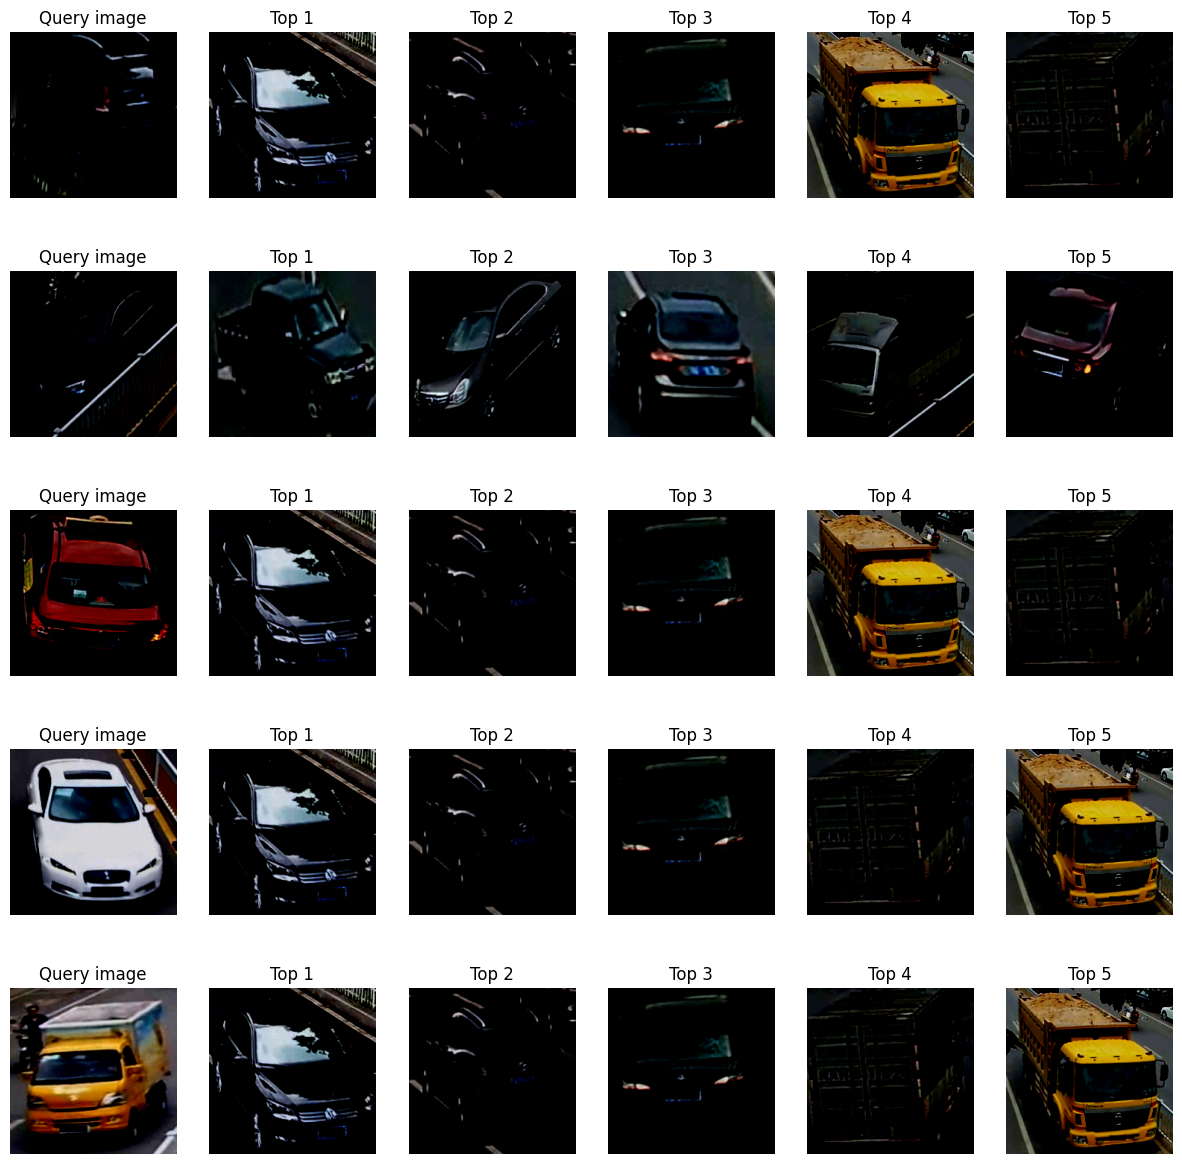

In [ ]:
indexes = np.random.choice(range(len(query_set)), size=5)
visual_inspect(indexes, distances)

According to this figure, the top 1 images and query images look like same vehicles. But over top 3 images, the difference is starting to be felt.

To quantify this result, let us compute now top-1 accuracy and tp-5 accuracy.

In [ ]:
top1 = 0.0
top5 = 0.0
for i in tqdm(range(len(query_set)), desc='Computing accuracy....'):
  query_image, query_label = query_set[i]
  id_top5 = get_top5(i, distances)
  if test_set[id_top5[0]][1] == query_label:
    top1 += 1.0
  if query_label in [test_set[j][1] for j in id_top5]:
    top5 += 1.0
top1_acc = top1/len(query_set)
top5_acc = top5/len(query_set)

Computing accuracy....: 100%|██████████| 1678/1678 [00:41<00:00, 40.23it/s]


In [ ]:
print('Top 1 accuracy = '+str(round(100*top1_acc,2))+'%')
print('Top 5 accuracy = '+str(round(100*top5_acc,2))+'%')

Top 1 accuracy = 0.42%
Top 5 accuracy = 3.93%


Over the images suggested by the model on the test set as similar to the query images, only 0.42% of the first suggested images are really similar. And 3.93% of the first 5 images are really similar.

The weakness of these accuracies may stem from the fact that not only did we train the model on only 5,000 images instead of 50,000, but we also didn't take all the triplets into account. Taking these shortcomings into account would surely increase accuracy.


# References

[1] https://github.com/JDAI-CV/VeRidataset

[2] https://pytorch.org/docs/stable/index.html

[3]